# Small World Graphs

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [21]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

from utils import decorate, savefig

# I set the random seed so the notebook 
# produces the same results every time.
np.random.seed(17)

# TODO: remove this when NetworkX is fixed
from warnings import simplefilter
import matplotlib.cbook
simplefilter("ignore", matplotlib.cbook.mplDeprecation)

In [22]:
# node colors for drawing networks
colors = sns.color_palette('pastel', 5)
#sns.palplot(colors)
sns.set_palette(colors)

## Regular ring lattice

To make a ring lattice, I'll start with a generator function that yields edges between each node and the next `halfk` neighbors.

In [23]:
def adjacent_edges(nodes, halfk):
    """Yields edges between each node and `halfk` neighbors.
    
    halfk: number of edges from each node
    """
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v

We can test it with 3 nodes and `halfk=1`

In [24]:
nodes = range(6)
for edge in adjacent_edges(nodes, 1):
    print(edge)

(0, 1)
(1, 2)
(2, 3)
(3, 4)
(4, 5)
(5, 0)


Now we use `adjacent_edges` to write `make_ring_lattice`

In [25]:
def make_ring_lattice(n, k):
    """Makes a ring lattice with `n` nodes and degree `k`.
    
    Note: this only works correctly if k is even.
    
    n: number of nodes
    k: degree of each node
    """
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

And we can test it out with `n=10` and `k=4`

In [26]:
lattice = make_ring_lattice(10, 6)

Saving figure to file figs/chap03-1


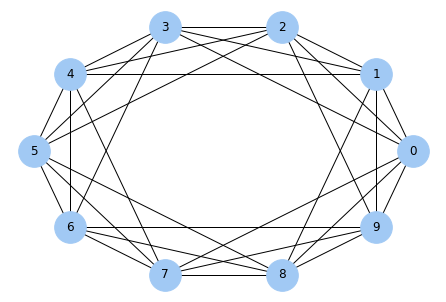

In [27]:
nx.draw_circular(lattice, 
                 node_color='C0', 
                 node_size=1000, 
                 with_labels=True)

savefig('figs/chap03-1')

**Exercise:** To see how this function fails when `k` is odd, run it again with `k=3` or `k=5`.

## WS graph

To make a WS graph, you start with a ring lattice and then rewire.

In [66]:
def make_ws_graph(n, k, p):
    """Makes a Watts-Strogatz graph.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring an edge
    """
    ws = make_ring_lattice(n, k)
    rewire(ws, p)
    return ws

Here's the function that does the rewiring

In [67]:
def rewire(G, p):
    """Rewires each edge with probability `p`.
    
    G: Graph
    p: float
    """
    nodes = set(G)
    for u, v in G.edges():
        if flip(p):
            choices = nodes - {u} - set(G[u])
            new_v = np.random.choice(list(choices))
            G.remove_edge(u, v)
            G.add_edge(u, new_v)
            
def flip(p):
    """Returns True with probability `p`."""
    return np.random.random() < p

Here's an example with `p=0.2`

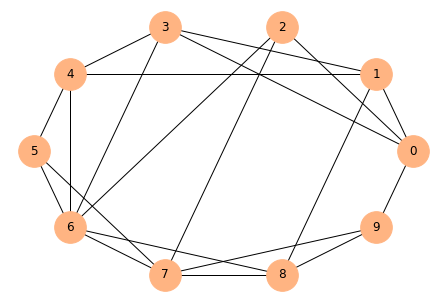

In [68]:
ws = make_ws_graph(10, 4, 0.2)
nx.draw_circular(ws, 
                 node_color='C1', 
                 node_size=1000, 
                 with_labels=True)

Just checking that we have the same number of edges we started with:

In [69]:
len(lattice.edges()), len(ws.edges())

(30, 20)

Now I'll generate a plot that shows WS graphs for a few values of `p`

Saving figure to file figs/chap03-2


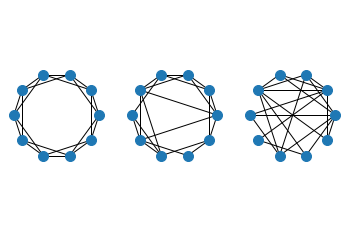

In [70]:
n = 10
k = 4
ns = 100

plt.subplot(1,3,1)
ws = make_ws_graph(n, k, 0)
nx.draw_circular(ws, node_size=ns)
plt.axis('equal')

plt.subplot(1,3,2)
ws = make_ws_graph(n, k, 0.2)
nx.draw_circular(ws, node_size=ns)
plt.axis('equal')

plt.subplot(1,3,3)
ws = make_ws_graph(n, k, 1.0)
nx.draw_circular(ws, node_size=ns)
plt.axis('equal')

#TODO: Set figure size
savefig('figs/chap03-2')

**Exercise:** What is the order of growth of `rewire`?

In [71]:
# Solution goes here
#O(n) because it loops through G which is linear in the number of nodes of G

## Clustering

The following function computes the local clustering coefficient for a given node, `u`:

In [72]:
def node_clustering(G, u):
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    returns: float
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return np.nan
        
    possible = k * (k-1) / 2
    exist = 0    
    for v, w in all_pairs(neighbors):
        if G.has_edge(v, w):
            exist +=1
    return exist / possible

def all_pairs(nodes):
    """Generates all pairs of nodes."""
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v

The network average clustering coefficient is just the mean of the local CCs.

In [73]:
def clustering_coefficient(G):
    """Average of the local clustering coefficients.
    
    G: Graph
    
    returns: float
    """
    cu = [node_clustering(G, node) for node in G]
    return np.nanmean(cu)

In a ring lattice with `k=4`, the clustering coefficient for each node should be 0.5

In [74]:
lattice = make_ring_lattice(10, 4)
node_clustering(lattice, 1)

0.5

And the network average should be 0.5

In [75]:
clustering_coefficient(lattice)

0.5

Correct.

In [44]:
%timeit clustering_coefficient(lattice)

171 µs ± 9.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


**Exercise:** Write a version of `node_clustering` that replaces the `for` loop with a list comprehension.  Is it faster?

In [42]:
# Solution goes here
def node_clustering_altered(G, u):
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    returns: float
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return np.nan
        
    possible = k * (k-1) / 2
    exist_new = [v for v,w in all_pairs(neighbors) if G.has_edge(v, w)]
    exist = len(exist_new)
    return exist / possible

def clustering_coefficient_altered(G):
    """Average of the local clustering coefficients.
    
    G: Graph
    
    returns: float
    """
    cu = [node_clustering_altered(G, node) for node in G]
    return np.nanmean(cu)

In [45]:
%timeit clustering_coefficient_altered(lattice)

202 µs ± 10.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


0.5

**Exercise:** What is the order of growth of `clustering_coefficient` in terms of `n`, `m`, and `k`?

In [21]:
# Solution goes here
#The order is O(n + m)

## Path length

The following function computes path lengths between all pairs of nodes

In [16]:
def path_lengths(G):
    length_iter = nx.shortest_path_length(G)
    for source, dist_map in length_iter:
        for dest, dist in dist_map.items():
            yield dist

The characteristic path length is the mean path length for all pairs.

In [17]:
def characteristic_path_length(G):
    return np.mean(list(path_lengths(G)))

On a complete graph, the average path length should be 1

In [51]:
complete = nx.complete_graph(10)
characteristic_path_length(complete)

0.9

On a ring lattice with `n=1000` and `k=10`, the mean is about 50

In [52]:
lattice = make_ring_lattice(1000, 10)
characteristic_path_length(lattice)

50.4

**Exercise:**  What is the mean path length in a ring lattice with `n=10` and `k=4`?

In [53]:
# Solution goes here
lattice = make_ring_lattice(10, 4)
characteristic_path_length(lattice)

1.5

## The experiment

This function generates a WS graph with the given parameters and returns a pair of (mean path length, clustering coefficient):

In [76]:
def run_one_graph(n, k, p):
    """Makes a WS graph and computes its stats.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring
    
    returns: tuple of (mean path length, clustering coefficient)
    """
    ws = make_ws_graph(n, k, p)    
    mpl = characteristic_path_length(ws)
    cc = clustering_coefficient(ws)
    print(mpl, cc)
    return mpl, cc

With `n=1000` and `k=10`, it takes a few seconds on my computer:

In [77]:
%time run_one_graph(1000, 10, 0.01)

8.162078 0.6428959595959596
Wall time: 9.41 s


(8.162078, 0.6428959595959596)

Now we'll run it with a range of values for `p`.

In [78]:
ps = np.logspace(-4, 0, 9)
print(ps)

[1.00000000e-04 3.16227766e-04 1.00000000e-03 3.16227766e-03
 1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00]


This function runs each value of `p` 20 times and returns a dictionary that maps from each `p` to a list of (mpl, cc) pairs.

In [56]:
def run_experiment(ps, n=1000, k=10, iters=20):
    """Computes stats for WS graphs with a range of `p`.
    
    ps: sequence of `p` to try
    n: number of nodes
    k: degree of each node
    iters: number of times to run for each `p`
    
    returns:
    """
    res = []
    for p in ps:
        print(p)
        t = [run_one_graph(n, k, p) for _ in range(iters)]
        means = np.array(t).mean(axis=0)
        print(means)
        res.append(means)
    return np.array(res)

Here are the raw results.  Warning: this takes a few minutes to run.

In [79]:
%time res = run_experiment(ps)

0.0001
40.57323 0.6662065656565656
50.4 0.6666666666666665
50.4 0.6666666666666665
42.339582 0.6662065656565656
50.4 0.6666666666666665
47.164194 0.6664232323232322
50.4 0.6666666666666665
49.967736 0.6661343434343433
40.016814 0.6662787878787878
50.4 0.6666666666666665
50.4 0.6666666666666665
50.4 0.6666666666666665
50.4 0.6666666666666665
39.767096 0.6656742424242422
37.91298 0.6659631313131312
50.208114 0.6661343434343433
50.4 0.6666666666666665
39.697288 0.6663510101010099
50.4 0.6666666666666665
50.4 0.6666666666666665
[47.1023517   0.66643528]
0.00031622776601683794
38.463862 0.6663510101010099
32.58725 0.6654252525252525
37.205762 0.665890909090909
26.609504 0.6653585858585858
36.489624 0.6660353535353534
34.631614 0.6656020202020202
41.650582 0.6662787878787878
45.419386 0.666179797979798
33.514678 0.6661075757575756
38.557846 0.6662787878787878
32.04731 0.6651484848484848
33.337198 0.6656020202020202
38.758942 0.6662787878787877
45.688598 0.6662787878787878
43.300572 0.6657464

In [57]:
res

NameError: name 'res' is not defined

Let's get the results into a form that's easy to plot.

In [80]:
L, C = np.transpose(res)

In [81]:
L

array([47.1023517 , 38.3981881 , 27.6171755 , 16.0545862 ,  8.9522581 ,
        6.0386897 ,  4.4986048 ,  3.6634676 ,  3.26444302])

In [82]:
C

array([0.66643528, 0.66594687, 0.6646746 , 0.66086172, 0.64772504,
       0.60932228, 0.49966141, 0.26106174, 0.01350781])

And normalize them so they both start at 1.0

In [83]:
L /= L[0]
C /= C[0]

Here's the plot that replicates Watts and Strogatz's Figure 2.

Saving figure to file figs/chap03-3


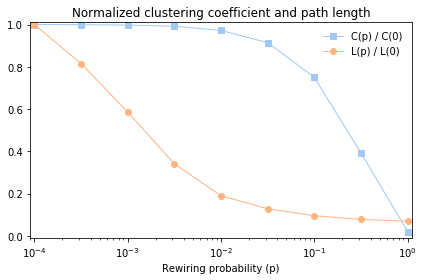

In [84]:
plt.plot(ps, C, 's-', linewidth=1, label='C(p) / C(0)')
plt.plot(ps, L, 'o-', linewidth=1, label='L(p) / L(0)')
decorate(xlabel='Rewiring probability (p)', xscale='log',
         title='Normalized clustering coefficient and path length',
         xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])

savefig('figs/chap03-3')

## Breadth-first search

Now let's see how the shortest path algorithm works.  We'll start with BFS, which is the basis for Dijkstra's algorithm.

Here's our old friend, the ring lattice:

In [95]:
lattice = make_ring_lattice(10, 8)

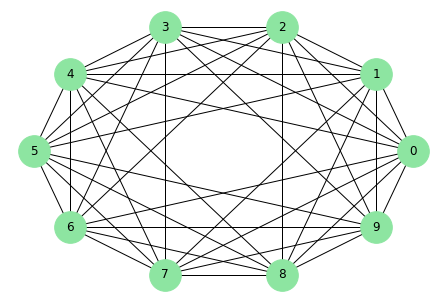

In [96]:
nx.draw_circular(lattice, 
                 node_color='C2', 
                 node_size=1000, 
                 with_labels=True)

And here's my implementation of BFS using a deque.

In [28]:
from collections import deque

def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            queue.extend(G.neighbors(node))
    return seen

It works:

In [29]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Here's a version that's a little faster, but maybe less readable.

In [30]:
def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            neighbors = set(G[node]) - seen
            queue.extend(neighbors)
    return seen

It works, too.

In [90]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Dijkstra's algorithm

Now we're ready for Dijkstra's algorithm, at least for graphs where all the edges have the same weight/length.

In [31]:
def shortest_path_dijkstra(G, source):
    """Finds shortest paths from `source` to all other nodes.
    
    G: graph
    source: node to start at
    
    returns: make from node to path length
    """
    dist = {source: 0}
    queue = deque([source])
    while queue:
        node = queue.popleft()
        new_dist = dist[node] + 1

        neighbors = set(G[node]).difference(dist)
        for n in neighbors:
            dist[n] = new_dist
        
        queue.extend(neighbors)
    return dist

Again, we'll test it on a ring lattice.

In [32]:
lattice = make_ring_lattice(10, 4)

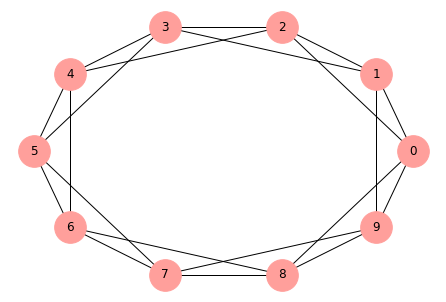

In [33]:
nx.draw_circular(lattice, 
                 node_color='C3', 
                 node_size=1000, 
                 with_labels=True)

Here's my implementation:

In [65]:
d1 = shortest_path_dijkstra(lattice, 0)
d1

{0: 0, 8: 1, 1: 1, 2: 1, 9: 1, 6: 2, 7: 2, 3: 2, 4: 2, 5: 3}

And here's the result from NetworkX:

In [35]:
d2 = nx.shortest_path_length(lattice, 0)
d2

{0: 0, 1: 1, 2: 1, 8: 1, 9: 1, 3: 2, 4: 2, 6: 2, 7: 2, 5: 3}

They are the same:

In [36]:
d1 == d2

True

**Exercise:** In a ring lattice with `n=1000` and `k=10`, which node is farthest from 0 and how far is it?  Use `shortest_path_dijkstra` to check your answer.

Note: the maximum distance between two nodes is the **diameter** of the graph.

In [103]:
# Solution goes here
lattice = make_ring_lattice(1000, 10)
shortest_path_dijkstra(lattice, 0)

{0: 0,
 1: 1,
 2: 1,
 3: 1,
 4: 1,
 5: 1,
 995: 1,
 996: 1,
 997: 1,
 998: 1,
 999: 1,
 6: 2,
 7: 2,
 8: 2,
 9: 2,
 10: 2,
 992: 2,
 993: 2,
 994: 2,
 990: 2,
 991: 2,
 11: 3,
 12: 3,
 13: 3,
 14: 3,
 15: 3,
 987: 3,
 988: 3,
 989: 3,
 985: 3,
 986: 3,
 16: 4,
 17: 4,
 18: 4,
 19: 4,
 20: 4,
 984: 4,
 982: 4,
 983: 4,
 980: 4,
 981: 4,
 21: 5,
 22: 5,
 23: 5,
 24: 5,
 25: 5,
 979: 5,
 977: 5,
 978: 5,
 976: 5,
 975: 5,
 26: 6,
 27: 6,
 28: 6,
 29: 6,
 30: 6,
 974: 6,
 972: 6,
 973: 6,
 971: 6,
 970: 6,
 31: 7,
 32: 7,
 33: 7,
 34: 7,
 35: 7,
 969: 7,
 968: 7,
 967: 7,
 966: 7,
 965: 7,
 36: 8,
 37: 8,
 38: 8,
 39: 8,
 40: 8,
 964: 8,
 963: 8,
 962: 8,
 961: 8,
 960: 8,
 41: 9,
 42: 9,
 43: 9,
 44: 9,
 45: 9,
 959: 9,
 958: 9,
 957: 9,
 956: 9,
 955: 9,
 46: 10,
 47: 10,
 48: 10,
 49: 10,
 50: 10,
 954: 10,
 953: 10,
 952: 10,
 951: 10,
 950: 10,
 51: 11,
 52: 11,
 53: 11,
 54: 11,
 55: 11,
 949: 11,
 948: 11,
 947: 11,
 946: 11,
 945: 11,
 56: 12,
 57: 12,
 58: 12,
 59: 12,
 60: 12,
 9

## Exercises

**Exercise:** In a ring lattice, every node has the same number of neighbors.  The number of neighbors is called the **degree** of the node, and a graph where all nodes have the same degree is called a **regular graph**.

All ring lattices are regular, but not all regular graphs are ring lattices.  In particular, if `k` is odd, we can't construct a ring lattice, but we might be able to construct a regular graph.

Write a function called `make_regular_graph` that takes `n` and `k` and returns a regular graph that contains `n` nodes, where every node has `k` neighbors.  If it's not possible to make a regular graph with the given values of `n` and `k`, the function should raise a `ValueError`.

In [51]:
# Solution goes here
def adjacent_edges(nodes, halfk):
    """Yields edges between each node and `halfk` neighbors.
    
    halfk: number of edges from each node
    """
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v

def make_ring_lattice(n, k):
    """Makes a ring lattice with `n` nodes and degree `k`.
    
    Note: this only works correctly if k is even.
    
    n: number of nodes
    k: degree of each node
    """
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

In [52]:
# Solution goes here


def opposite_edges(nodes):
    """Enumerates edges that connect opposite nodes."""
    n = len(nodes)
    for i, u in enumerate(nodes):
        j = i + n//2
        v = nodes[j % n]
        yield u, v
        


def make_regular_graph(n, k):
    nodes = range(n)
    for i,u in enumerate(nodes):
        
        

In [53]:
# Solution goes here

In [48]:
# Solution goes here

{3}

**Exercise:** My implementation of `reachable_nodes_bfs` is efficient in the sense that it is in $O(n + m)$, but it incurs a lot of overhead adding nodes to the queue and removing them.  NetworkX provides a simple, fast implementation of BFS, available from [the NetworkX repository on GitHub](https://github.com/networkx/networkx/blob/master/networkx/algorithms/components/connected.py).

Here is a version I modified to return a set of nodes:

In [37]:
def plain_bfs(G, start):
    """A fast BFS node generator"""
    seen = set()
    nextlevel = {start}
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel:
            if v not in seen:
                seen.add(v)
                nextlevel.update(G[v])
    return seen

Compare this function to `reachable_nodes_bfs` and see which is faster.  Then see if you can modify this function to implement a faster version of `shortest_path_dijkstra`

In [51]:
# Solution goes here
plain_bfs(lattice, 5)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [39]:
# Solution goes here
%time reachable_nodes_bfs(lattice,0)

Wall time: 0 ns


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [152]:
#Solution goes here
def plain_bfs_dj2(G, start):
    """A fast BFS node generator"""
    seen = set()
    nextlevel = {start}
    dist = {start:0}
    node = start
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        new_dist = dist[node] + 1
        for v in thislevel:
            if v not in seen:
                seen.add(v)
                node = v
                nextlevel.update(G[v])
                dist[v] = new_dist
    return dist




In [153]:
# Solution goes here
plain_bfs_dj2(lattice, 0)
#I am really close here but it increases the counter in the first loop when the level is still {0,0} 
#and I can't figure out how to ignore it for that level, so every path length is one too long

{0: 1, 8: 2, 1: 2, 2: 2, 9: 2, 3: 3, 4: 3, 6: 3, 7: 3, 5: 4}

In [142]:
# Solution goes here


In [143]:
# Solution goes here


In [144]:
# Solution goes here


In [145]:
# Solution goes here


**Exercise:** The following implementation of a BFS contains two performance errors.  What are
they?  What is the actual order of growth for this algorithm?

In [146]:
def bfs(G, start):
    """Breadth-first search on a graph, starting at top_node."""
    visited = set()
    queue = [start]
    while len(queue):
        curr_node = queue.pop(0)    # Dequeue
        visited.add(curr_node)

        # Enqueue non-visited and non-enqueued children
        queue.extend(c for c in G[curr_node]
                     if c not in visited and c not in queue)
    return visited

In [147]:
# Solution goes here
# The queue wasn't declared as a deque so it is removing from the left of a normal queue which is linear in time not constant
# 

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

**Exercise:** In the book, I claimed that Dijkstra's algorithm does not work unless it uses BFS.  Write a version of `shortest_path_dijkstra` that uses DFS and test it on a few examples to see what goes wrong.

In [148]:
# Solution goes here
def shortest_path_dijkstra_dfs(G, source):
    """Finds shortest paths from `source` to all other nodes.
    
    G: graph
    source: node to start at
    
    returns: make from node to path length
    """
    dist = {source: 0}
    queue = deque([source])
    while queue:
        node = queue.pop()
        new_dist = dist[node] + 1

        neighbors = set(G[node]).difference(dist)
        for n in neighbors:
            dist[n] = new_dist
        
        queue.extend(neighbors)
    return dist




In [149]:
shortest_path_dijkstra_dfs(lattice,0)

{0: 0, 8: 1, 1: 1, 2: 1, 9: 1, 7: 2, 5: 3, 6: 3, 4: 4, 3: 5}

In [150]:
shortest_path_dijkstra(lattice,0)

{0: 0, 8: 1, 1: 1, 2: 1, 9: 1, 6: 2, 7: 2, 3: 2, 4: 2, 5: 3}

In [ ]:
#By the time it reaches the end of the list our counter object (new_dist) gets too high because we have to re-visit nodes that 
# we had passed earlier